# Caso C: Modelado de Ticket Promedio (AOV Drivers)

## Contexto
Existe una alta variabilidad en el Ticket Promedio (AOV - Average Order Value) entre sucursales. Se requiere entender qué factores exógenos y endógenos influyen en este indicador.

## Objetivos
1. **Modelo Inferencial**: Determinar la importancia de las variables (feature importance) en el valor del ticket
2. **Modelo Predictivo**: Estimar el gasto esperado de un cliente recurrente en su próxima visita

## Datos Disponibles
- `transacciones_resumen.csv`: id_ticket, id_tienda, timestamp, total_venta, total_articulos, id_cliente
- `promociones_activas.csv`: fecha_inicio, fecha_fin, id_producto, tipo_descuento, id_tienda
- `variables_exogenas.csv`: fecha, id_tienda, clima, competitor_price_index, indice_trafico
- `clientes_loyalty.csv`: id_cliente, fecha_registro, edad, segmento

## Enfoque
Desarrollaremos dos modelos:
1. **Modelo de Regresión**: Para predecir el valor exacto del ticket (usando RMSE, MAE, R², MAPE)
2. **Modelo de Clasificación**: Para predecir si el ticket será "alto" o "bajo" (usando F1, AUC, Accuracy)

In [1]:
# Importaciones
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 1. Carga de Datos

In [2]:
# Cargar datos
transacciones = pd.read_csv('../data/03_aov_drivers/transacciones_resumen.csv')
clientes = pd.read_csv('../data/03_aov_drivers/clientes_loyalty.csv')
promociones = pd.read_csv('../data/03_aov_drivers/promociones_activas.csv')
variables_exogenas = pd.read_csv('../data/03_aov_drivers/variables_exogenas.csv')

print("📊 Datos cargados:")
print(f"  - Transacciones: {transacciones.shape}")
print(f"  - Clientes: {clientes.shape}")
print(f"  - Promociones: {promociones.shape}")
print(f"  - Variables Exógenas: {variables_exogenas.shape}")

📊 Datos cargados:
  - Transacciones: (10000, 6)
  - Clientes: (1000, 4)
  - Promociones: (493, 5)
  - Variables Exógenas: (910, 5)


In [3]:
# Vista previa de los datos
print("\n📋 TRANSACCIONES:")
display(transacciones.head())
print(f"\nInfo:")
print(transacciones.info())
print(f"\nEstadísticas descriptivas:")
display(transacciones.describe())


📋 TRANSACCIONES:


,id_ticket,id_tienda,timestamp,total_venta,total_articulos,id_cliente
0,TICKET_0000001,STORE_10,2024-03-31 14:27:00,3.61,1,CUST_00647
1,TICKET_0000002,STORE_05,2024-03-22 13:51:00,38.40,4,CUST_00500
2,TICKET_0000003,STORE_07,2024-02-18 13:00:00,41.32,4,CUST_00977
3,TICKET_0000004,STORE_03,2024-02-23 19:39:00,2.97,1,CUST_00866
4,TICKET_0000005,STORE_05,2024-03-06 11:42:00,23.95,2,CUST_00846



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_ticket        10000 non-null  object 
 1   id_tienda        10000 non-null  object 
 2   timestamp        10000 non-null  object 
 3   total_venta      10000 non-null  float64
 4   total_articulos  10000 non-null  int64  
 5   id_cliente       10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB
None

Estadísticas descriptivas:


,total_venta,total_articulos
count,10000.000000,10000.000000
mean,17.940067,2.252000
std,11.083411,1.191653
min,2.190000,1.000000
25%,9.310000,1.000000
50%,15.490000,2.000000
75%,24.362500,3.000000
max,67.400000,7.000000


In [4]:
print("\n👥 CLIENTES:")
display(clientes.head())
print(f"\nInfo:")
print(clientes.info())
print(f"\nDistribución de segmentos:")
print(clientes['segmento'].value_counts())


👥 CLIENTES:


,id_cliente,fecha_registro,edad,segmento
0,CUST_00001,2023-04-30,51,Regular
1,CUST_00002,2023-10-17,22,Budget
2,CUST_00003,2023-06-09,57,Regular
3,CUST_00004,2022-08-31,20,Budget
4,CUST_00005,2023-11-13,19,Budget



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_cliente      1000 non-null   object
 1   fecha_registro  1000 non-null   object
 2   edad            1000 non-null   int64 
 3   segmento        1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None

Distribución de segmentos:
segmento
Regular    495
Budget     303
Premium    202
Name: count, dtype: int64


In [5]:
print("\n🎁 PROMOCIONES:")
display(promociones.head())
print(f"\nInfo:")
print(promociones.info())
print(f"\nTipos de descuento:")
print(promociones['tipo_descuento'].value_counts())


🎁 PROMOCIONES:


,fecha_inicio,fecha_fin,id_producto,tipo_descuento,id_tienda
0,2024-02-07,2024-02-18,PROD_034,Fixed_Amount,STORE_06
1,2024-02-07,2024-02-18,PROD_034,Fixed_Amount,STORE_08
2,2024-02-07,2024-02-18,PROD_034,Fixed_Amount,STORE_10
3,2024-02-18,2024-02-22,PROD_031,Fixed_Amount,STORE_03
4,2024-02-18,2024-02-22,PROD_031,Fixed_Amount,STORE_09



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   fecha_inicio    493 non-null    object
 1   fecha_fin       493 non-null    object
 2   id_producto     493 non-null    object
 3   tipo_descuento  493 non-null    object
 4   id_tienda       493 non-null    object
dtypes: object(5)
memory usage: 19.4+ KB
None

Tipos de descuento:
tipo_descuento
Fixed_Amount    177
Percentage      158
2x1             158
Name: count, dtype: int64


In [6]:
print("\n🌤️ VARIABLES EXÓGENAS:")
display(variables_exogenas.head())
print(f"\nInfo:")
print(variables_exogenas.info())
print(f"\nClimas:")
print(variables_exogenas['clima'].value_counts())


🌤️ VARIABLES EXÓGENAS:


,fecha,id_tienda,clima,competitor_price_index,indice_trafico
0,2024-01-01,STORE_01,Sunny,1.01,85.6
1,2024-01-01,STORE_02,Sunny,1.01,49.5
2,2024-01-01,STORE_03,Sunny,1.03,55.2
3,2024-01-01,STORE_04,Sunny,1.00,80.6
4,2024-01-01,STORE_05,Sunny,0.99,83.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fecha                   910 non-null    object 
 1   id_tienda               910 non-null    object 
 2   clima                   910 non-null    object 
 3   competitor_price_index  910 non-null    float64
 4   indice_trafico          910 non-null    float64
dtypes: float64(2), object(3)
memory usage: 35.7+ KB
None

Climas:
clima
Sunny     420
Cloudy    310
Rainy     180
Name: count, dtype: int64


## 2. Análisis Exploratorio de Datos (EDA)

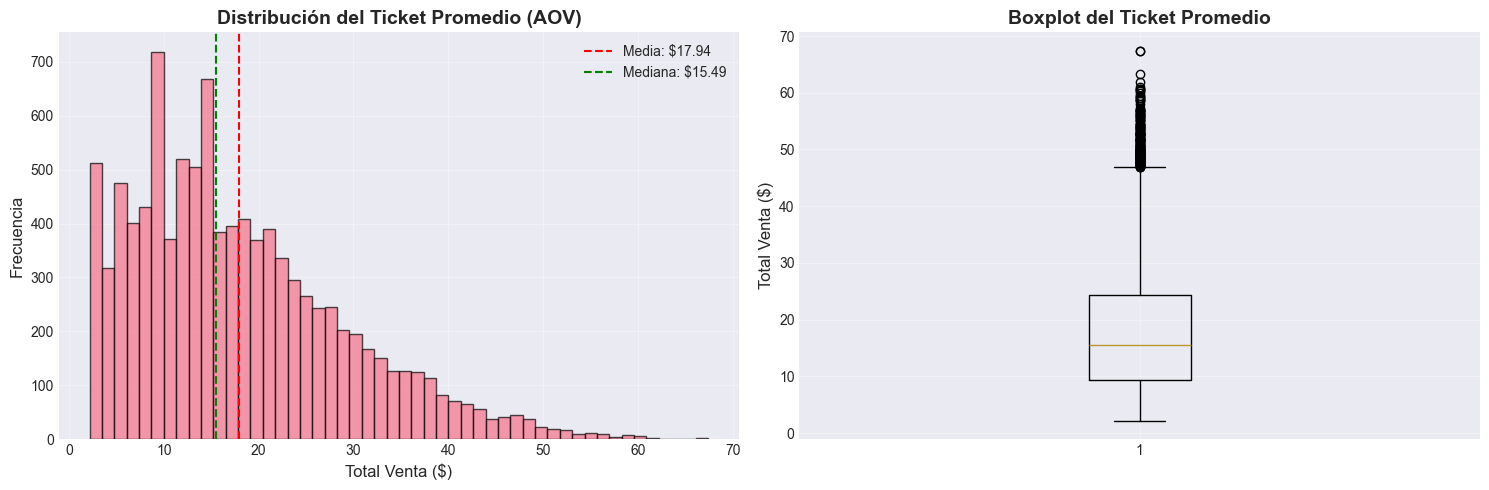


📊 Estadísticas del Ticket Promedio:
  - Media: $17.94
  - Mediana: $15.49
  - Desviación Estándar: $11.08
  - Mínimo: $2.19
  - Máximo: $67.40
  - Q1 (25%): $9.31
  - Q3 (75%): $24.36


In [7]:
# Distribución del ticket promedio (AOV)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
axes[0].hist(transacciones['total_venta'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(transacciones['total_venta'].mean(), color='red', linestyle='--', 
                label=f'Media: ${transacciones["total_venta"].mean():.2f}')
axes[0].axvline(transacciones['total_venta'].median(), color='green', linestyle='--', 
                label=f'Mediana: ${transacciones["total_venta"].median():.2f}')
axes[0].set_xlabel('Total Venta ($)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución del Ticket Promedio (AOV)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot(transacciones['total_venta'], vert=True)
axes[1].set_ylabel('Total Venta ($)', fontsize=12)
axes[1].set_title('Boxplot del Ticket Promedio', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Estadísticas del Ticket Promedio:")
print(f"  - Media: ${transacciones['total_venta'].mean():.2f}")
print(f"  - Mediana: ${transacciones['total_venta'].median():.2f}")
print(f"  - Desviación Estándar: ${transacciones['total_venta'].std():.2f}")
print(f"  - Mínimo: ${transacciones['total_venta'].min():.2f}")
print(f"  - Máximo: ${transacciones['total_venta'].max():.2f}")
print(f"  - Q1 (25%): ${transacciones['total_venta'].quantile(0.25):.2f}")
print(f"  - Q3 (75%): ${transacciones['total_venta'].quantile(0.75):.2f}")

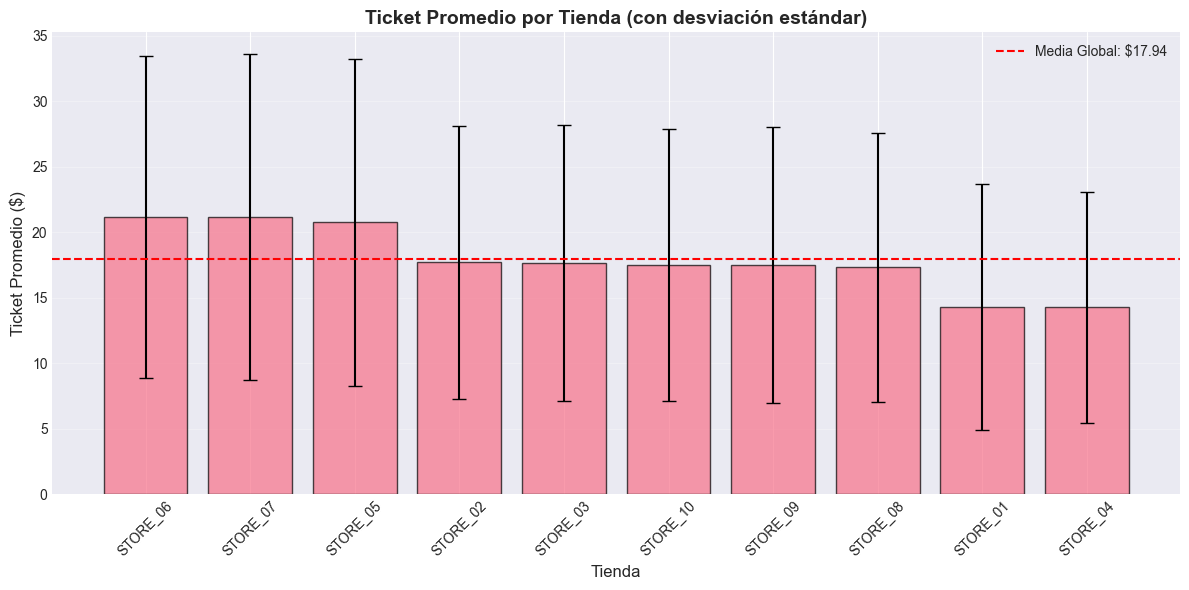


📍 Ticket Promedio por Tienda:


,id_tienda,aov_mean,aov_median,aov_std,n_transacciones
5,STORE_06,21.191653,19.565,12.292309,998
6,STORE_07,21.156448,19.480,12.436693,1005
4,STORE_05,20.773470,18.905,12.471582,1026
1,STORE_02,17.714632,15.630,10.394873,991
2,STORE_03,17.685031,15.595,10.529221,976
9,STORE_10,17.509911,15.455,10.410522,1006
8,STORE_09,17.497375,15.310,10.536114,960
7,STORE_08,17.333958,15.290,10.290778,998
0,STORE_01,14.298708,12.430,9.404744,1014
3,STORE_04,14.277943,12.765,8.837796,1026


In [8]:
# Ticket promedio por tienda
aov_por_tienda = transacciones.groupby('id_tienda')['total_venta'].agg(['mean', 'median', 'std', 'count']).reset_index()
aov_por_tienda.columns = ['id_tienda', 'aov_mean', 'aov_median', 'aov_std', 'n_transacciones']
aov_por_tienda = aov_por_tienda.sort_values('aov_mean', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(aov_por_tienda))
ax.bar(x, aov_por_tienda['aov_mean'], yerr=aov_por_tienda['aov_std'], 
       capsize=5, alpha=0.7, edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(aov_por_tienda['id_tienda'], rotation=45)
ax.set_xlabel('Tienda', fontsize=12)
ax.set_ylabel('Ticket Promedio ($)', fontsize=12)
ax.set_title('Ticket Promedio por Tienda (con desviación estándar)', fontsize=14, fontweight='bold')
ax.axhline(transacciones['total_venta'].mean(), color='red', linestyle='--', 
           label=f'Media Global: ${transacciones["total_venta"].mean():.2f}')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n📍 Ticket Promedio por Tienda:")
display(aov_por_tienda)

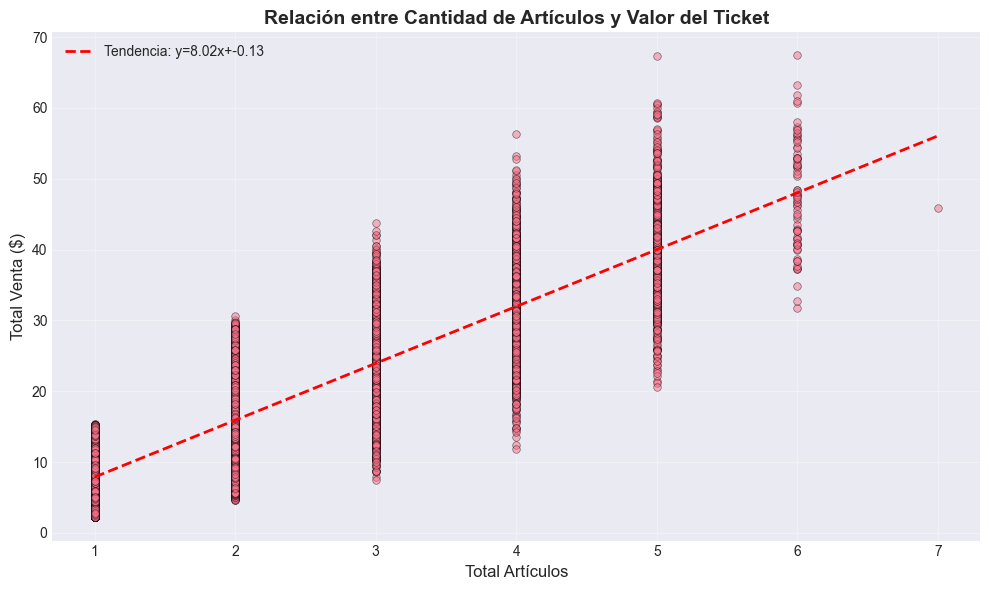


📈 Correlación entre total_articulos y total_venta: 0.863


In [9]:
# Relación entre total_articulos y total_venta
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(transacciones['total_articulos'], transacciones['total_venta'], 
                     alpha=0.5, s=30, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Total Artículos', fontsize=12)
ax.set_ylabel('Total Venta ($)', fontsize=12)
ax.set_title('Relación entre Cantidad de Artículos y Valor del Ticket', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Línea de tendencia
z = np.polyfit(transacciones['total_articulos'], transacciones['total_venta'], 1)
p = np.poly1d(z)
ax.plot(transacciones['total_articulos'].sort_values(), 
        p(transacciones['total_articulos'].sort_values()), 
        "r--", linewidth=2, label=f'Tendencia: y={z[0]:.2f}x+{z[1]:.2f}')
ax.legend()

plt.tight_layout()
plt.show()

# Correlación
corr = transacciones[['total_articulos', 'total_venta']].corr().iloc[0, 1]
print(f"\n📈 Correlación entre total_articulos y total_venta: {corr:.3f}")

In [10]:
# Preparar dataset principal
df = transacciones.copy()

# Convertir timestamp a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['fecha'] = df['timestamp'].dt.date
df['fecha'] = pd.to_datetime(df['fecha'])

# Extraer features temporales
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['dayofweek'] = df['timestamp'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['hour'] = df['timestamp'].dt.hour
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

# Crear categorías de horario
def categorize_hour(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['hour'].apply(categorize_hour)

print("✅ Features temporales creadas")
print(f"\nNuevas columnas: {df.columns.tolist()}")

✅ Features temporales creadas

Nuevas columnas: ['id_ticket', 'id_tienda', 'timestamp', 'total_venta', 'total_articulos', 'id_cliente', 'fecha', 'year', 'month', 'day', 'dayofweek', 'hour', 'is_weekend', 'time_of_day']


In [11]:
# Merge con clientes
clientes['fecha_registro'] = pd.to_datetime(clientes['fecha_registro'])
df = df.merge(clientes, on='id_cliente', how='left')

# Calcular antigüedad del cliente
df['customer_age_days'] = (df['timestamp'] - df['fecha_registro']).dt.days
df['customer_age_months'] = df['customer_age_days'] / 30

print("✅ Datos de clientes integrados")
print(f"\nColumnas después del merge: {df.shape[1]}")
print(f"\nValores nulos en segmento: {df['segmento'].isna().sum()}")
print(f"Valores nulos en edad: {df['edad'].isna().sum()}")

✅ Datos de clientes integrados

Columnas después del merge: 19

Valores nulos en segmento: 0
Valores nulos en edad: 0


In [12]:
# Merge con variables exógenas
variables_exogenas['fecha'] = pd.to_datetime(variables_exogenas['fecha'])
df = df.merge(variables_exogenas, on=['fecha', 'id_tienda'], how='left')

print("✅ Variables exógenas integradas")
print(f"\nColumnas después del merge: {df.shape[1]}")
print(f"\nValores nulos en clima: {df['clima'].isna().sum()}")
print(f"Valores nulos en competitor_price_index: {df['competitor_price_index'].isna().sum()}")

✅ Variables exógenas integradas

Columnas después del merge: 22

Valores nulos en clima: 0
Valores nulos en competitor_price_index: 0


In [13]:
# Integrar promociones activas
# Contar cuántas promociones estaban activas para cada tienda en cada fecha
promociones['fecha_inicio'] = pd.to_datetime(promociones['fecha_inicio'])
promociones['fecha_fin'] = pd.to_datetime(promociones['fecha_fin'])

def count_active_promotions(row):
    """Cuenta promociones activas para una tienda en una fecha específica"""
    mask = (
        (promociones['id_tienda'] == row['id_tienda']) &
        (promociones['fecha_inicio'] <= row['fecha']) &
        (promociones['fecha_fin'] >= row['fecha'])
    )
    return mask.sum()

def get_promotion_types(row):
    """Obtiene los tipos de promociones activas"""
    mask = (
        (promociones['id_tienda'] == row['id_tienda']) &
        (promociones['fecha_inicio'] <= row['fecha']) &
        (promociones['fecha_fin'] >= row['fecha'])
    )
    types = promociones[mask]['tipo_descuento'].unique()
    return ','.join(types) if len(types) > 0 else 'none'

print("Calculando promociones activas...")
df['n_promociones_activas'] = df.apply(count_active_promotions, axis=1)
df['tipos_promociones'] = df.apply(get_promotion_types, axis=1)

# Crear flags para cada tipo de promoción
df['has_promo_2x1'] = df['tipos_promociones'].str.contains('2x1').astype(int)
df['has_promo_percentage'] = df['tipos_promociones'].str.contains('Percentage').astype(int)
df['has_promo_fixed'] = df['tipos_promociones'].str.contains('Fixed_Amount').astype(int)

print("✅ Promociones integradas")
print(f"\nDistribución de promociones activas:")
print(df['n_promociones_activas'].value_counts().sort_index())

Calculando promociones activas...
✅ Promociones integradas

Distribución de promociones activas:
n_promociones_activas
0      162
1      271
2      748
3     1301
4     1983
5     1501
6     1347
7     1009
8      800
9      505
10     254
11      67
12      13
13      33
14       6
Name: count, dtype: int64


In [14]:
# Crear features agregadas por cliente
customer_stats = df.groupby('id_cliente').agg({
    'total_venta': ['count', 'mean', 'std'],
    'total_articulos': 'mean'
}).reset_index()

customer_stats.columns = ['id_cliente', 'customer_n_transactions', 'customer_avg_ticket', 
                          'customer_ticket_std', 'customer_avg_items']

# Llenar NaN en std (clientes con una sola transacción)
customer_stats['customer_ticket_std'] = customer_stats['customer_ticket_std'].fillna(0)

df = df.merge(customer_stats, on='id_cliente', how='left')

print("✅ Features agregadas por cliente creadas")
print(f"\nEjemplo de features de cliente:")
display(customer_stats.head())

✅ Features agregadas por cliente creadas

Ejemplo de features de cliente:


,id_cliente,customer_n_transactions,customer_avg_ticket,customer_ticket_std,customer_avg_items
0,CUST_00001,9,14.725556,8.622046,2.000000
1,CUST_00002,15,12.898000,6.916672,1.533333
2,CUST_00003,11,13.381818,5.618953,1.818182
3,CUST_00004,7,13.821429,5.937807,1.428571
4,CUST_00005,9,13.488889,5.417943,1.555556


In [15]:
# Crear features agregadas por tienda
store_stats = df.groupby('id_tienda').agg({
    'total_venta': ['mean', 'std'],
    'total_articulos': 'mean',
    'indice_trafico': 'mean'
}).reset_index()

store_stats.columns = ['id_tienda', 'store_avg_ticket', 'store_ticket_std', 
                       'store_avg_items', 'store_avg_traffic']

df = df.merge(store_stats, on='id_tienda', how='left')

print("✅ Features agregadas por tienda creadas")
print(f"\nEjemplo de features de tienda:")
display(store_stats.head())

✅ Features agregadas por tienda creadas

Ejemplo de features de tienda:


,id_tienda,store_avg_ticket,store_ticket_std,store_avg_items,store_avg_traffic
0,STORE_01,14.298708,9.404744,1.800789,62.320020
1,STORE_02,17.714632,10.394873,2.246216,57.394551
2,STORE_03,17.685031,10.529221,2.228484,54.682070
3,STORE_04,14.277943,8.837796,1.783626,61.903509
4,STORE_05,20.773470,12.471582,2.615984,67.614620


In [16]:
# Crear target para clasificación (ticket alto vs bajo)
# Usaremos la mediana como umbral
median_ticket = df['total_venta'].median()
df['is_high_ticket'] = (df['total_venta'] > median_ticket).astype(int)

print(f"\n🎯 Target de clasificación creado:")
print(f"  - Umbral (mediana): ${median_ticket:.2f}")
print(f"  - Tickets altos: {df['is_high_ticket'].sum()} ({df['is_high_ticket'].mean()*100:.1f}%)")
print(f"  - Tickets bajos: {(1-df['is_high_ticket']).sum()} ({(1-df['is_high_ticket'].mean())*100:.1f}%)")


🎯 Target de clasificación creado:
  - Umbral (mediana): $15.49
  - Tickets altos: 4995 (50.0%)
  - Tickets bajos: 5005 (50.0%)


In [17]:
# Verificar dataset final
print("\n📊 Dataset Final:")
print(f"  - Shape: {df.shape}")
print(f"  - Columnas: {df.shape[1]}")
print(f"\nColumnas disponibles:")
print(df.columns.tolist())
print(f"\nValores nulos por columna:")
print(df.isnull().sum()[df.isnull().sum() > 0])


📊 Dataset Final:
  - Shape: (10000, 36)
  - Columnas: 36

Columnas disponibles:
['id_ticket', 'id_tienda', 'timestamp', 'total_venta', 'total_articulos', 'id_cliente', 'fecha', 'year', 'month', 'day', 'dayofweek', 'hour', 'is_weekend', 'time_of_day', 'fecha_registro', 'edad', 'segmento', 'customer_age_days', 'customer_age_months', 'clima', 'competitor_price_index', 'indice_trafico', 'n_promociones_activas', 'tipos_promociones', 'has_promo_2x1', 'has_promo_percentage', 'has_promo_fixed', 'customer_n_transactions', 'customer_avg_ticket', 'customer_ticket_std', 'customer_avg_items', 'store_avg_ticket', 'store_ticket_std', 'store_avg_items', 'store_avg_traffic', 'is_high_ticket']

Valores nulos por columna:
Series([], dtype: int64)


## 4. Análisis de Correlaciones

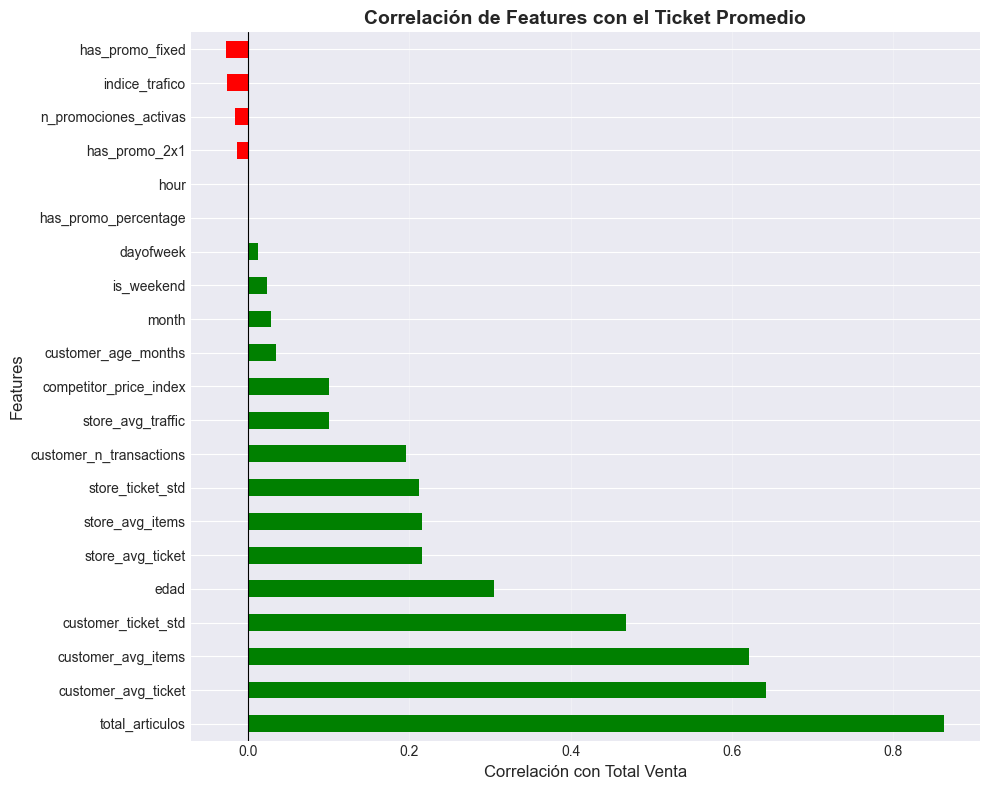


📊 Top 10 Features más correlacionadas con total_venta:
total_articulos            0.862784
customer_avg_ticket        0.642668
customer_avg_items         0.621294
customer_ticket_std        0.468209
edad                       0.304890
store_avg_ticket           0.215883
store_avg_items            0.215246
store_ticket_std           0.212500
customer_n_transactions    0.195894
store_avg_traffic          0.101158
Name: total_venta, dtype: float64


In [18]:
# Seleccionar features numéricas para correlación
numeric_features = [
    'total_articulos', 'edad', 'customer_age_months', 'competitor_price_index',
    'indice_trafico', 'n_promociones_activas', 'customer_n_transactions',
    'customer_avg_ticket', 'customer_ticket_std', 'customer_avg_items',
    'store_avg_ticket', 'store_ticket_std', 'store_avg_items', 'store_avg_traffic',
    'month', 'dayofweek', 'hour', 'is_weekend',
    'has_promo_2x1', 'has_promo_percentage', 'has_promo_fixed'
]

# Matriz de correlación con el target (total_venta)
correlations = df[numeric_features + ['total_venta']].corr()['total_venta'].drop('total_venta').sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
correlations.plot(kind='barh', ax=ax, color=['green' if x > 0 else 'red' for x in correlations])
ax.set_xlabel('Correlación con Total Venta', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Correlación de Features con el Ticket Promedio', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features más correlacionadas con total_venta:")
print(correlations.head(10))

## 5. Preparación de Datos para Modelado

In [19]:
# Definir features para el modelo
numerical_features = [
    'total_articulos',
    'edad',
    'customer_age_months',
    'competitor_price_index',
    'indice_trafico',
    'n_promociones_activas',
    'customer_n_transactions',
    'customer_avg_ticket',
    'customer_ticket_std',
    'customer_avg_items',
    'store_avg_ticket',
    'store_ticket_std',
    'store_avg_items',
    'store_avg_traffic',
    'month',
    'dayofweek',
    'hour',
    'is_weekend',
    'has_promo_2x1',
    'has_promo_percentage',
    'has_promo_fixed'
]

categorical_features = [
    'id_tienda',
    'segmento',
    'clima',
    'time_of_day'
]

# Metadata columns
metadata_cols = ['id_ticket', 'id_cliente', 'timestamp', 'fecha', 'fecha_registro', 
                 'tipos_promociones', 'year', 'day', 'customer_age_days']

print(f"✅ Features definidas:")
print(f"  - Numéricas: {len(numerical_features)}")
print(f"  - Categóricas: {len(categorical_features)}")
print(f"  - Metadata: {len(metadata_cols)}")

✅ Features definidas:
  - Numéricas: 21
  - Categóricas: 4
  - Metadata: 9


In [20]:
# Preparar dataset para modelado
model_df = df[numerical_features + categorical_features + ['total_venta', 'is_high_ticket']].copy()

# Verificar valores nulos
print(f"\n🔍 Valores nulos en el dataset de modelado:")
null_counts = model_df.isnull().sum()
if null_counts.sum() > 0:
    print(null_counts[null_counts > 0])
else:
    print("  ✅ No hay valores nulos")

print(f"\n📊 Shape del dataset: {model_df.shape}")


🔍 Valores nulos en el dataset de modelado:
  ✅ No hay valores nulos

📊 Shape del dataset: (10000, 27)


In [21]:
# Split estratificado para ambos modelos
from sklearn.model_selection import train_test_split

# Para regresión, estratificamos por bins del target
# Crear bins del target para estratificación
model_df['total_venta_bin'] = pd.qcut(model_df['total_venta'], q=5, labels=False, duplicates='drop')

# Split temporal: 70% train, 15% test, 15% validation
# Primero separamos train del resto
train_df, temp_df = train_test_split(
    model_df, 
    test_size=0.3, 
    stratify=model_df['is_high_ticket'],  # Estratificamos por clasificación
    random_state=42
)

# Luego separamos test y validation
test_df, val_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['is_high_ticket'],
    random_state=42
)

# Eliminar columna auxiliar
train_df = train_df.drop('total_venta_bin', axis=1)
test_df = test_df.drop('total_venta_bin', axis=1)
val_df = val_df.drop('total_venta_bin', axis=1)

print(f"✅ Datos divididos:")
print(f"  - Train: {train_df.shape} ({len(train_df)/len(model_df)*100:.1f}%)")
print(f"  - Test: {test_df.shape} ({len(test_df)/len(model_df)*100:.1f}%)")
print(f"  - Validation: {val_df.shape} ({len(val_df)/len(model_df)*100:.1f}%)")

print(f"\n📊 Distribución del target (is_high_ticket):")
print(f"  - Train: {train_df['is_high_ticket'].mean()*100:.1f}% tickets altos")
print(f"  - Test: {test_df['is_high_ticket'].mean()*100:.1f}% tickets altos")
print(f"  - Validation: {val_df['is_high_ticket'].mean()*100:.1f}% tickets altos")

✅ Datos divididos:
  - Train: (7000, 27) (70.0%)
  - Test: (1500, 27) (15.0%)
  - Validation: (1500, 27) (15.0%)

📊 Distribución del target (is_high_ticket):
  - Train: 50.0% tickets altos
  - Test: 49.9% tickets altos
  - Validation: 49.9% tickets altos


## 6. Modelo de Regresión - Predicción del Valor del Ticket

In [22]:
from src.model_manager import ModelManager

# Configuración del modelo de regresión
columns_config = {
    "numerical_features": numerical_features,
    "categorical_features": categorical_features,
    "target": ["total_venta"],
    "metadata": []
}

model_metadata = {
    "hyperparameters": {
        "n_estimators": 200,
        "max_depth": 6,
        "learning_rate": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "random_state": 42,
        "n_jobs": -1
    }
}

# Crear y entrenar modelo de regresión
print("🚀 Entrenando modelo de REGRESIÓN...")
regression_model = ModelManager(
    columns=columns_config,
    model_metadata=model_metadata,
    model_type="regression",
    scale_numeric=True  # Escalar features numéricas para regresión
)

regression_model.train_model(train_df)
print("✅ Modelo de regresión entrenado")

🚀 Entrenando modelo de REGRESIÓN...
✅ Modelo de regresión entrenado


In [23]:
# Evaluar modelo de regresión
artifacts_reg, metrics_reg = regression_model.evaluate_model(train_df, test_df, val_df)

print("\n📊 MÉTRICAS DEL MODELO DE REGRESIÓN:")
print("="*60)
metrics_reg_df = pd.DataFrame(metrics_reg)
for dataset in ['train', 'test', 'oot']:
    print(f"\n{dataset.upper()}:")
    dataset_metrics = metrics_reg_df[metrics_reg_df['dataset'] == dataset]
    for _, row in dataset_metrics.iterrows():
        print(f"  - {row['name']}: {row['value']:.4f}")


📊 MÉTRICAS DEL MODELO DE REGRESIÓN:

TRAIN:
  - rmse: 3.0315
  - mae: 2.3849
  - r2_score: 0.9249
  - mape: 0.2126

TEST:
  - rmse: 5.5469
  - mae: 4.3422
  - r2_score: 0.7472
  - mape: 0.3627

OOT:
  - rmse: 5.7011
  - mae: 4.4928
  - r2_score: 0.7416
  - mape: 0.3789


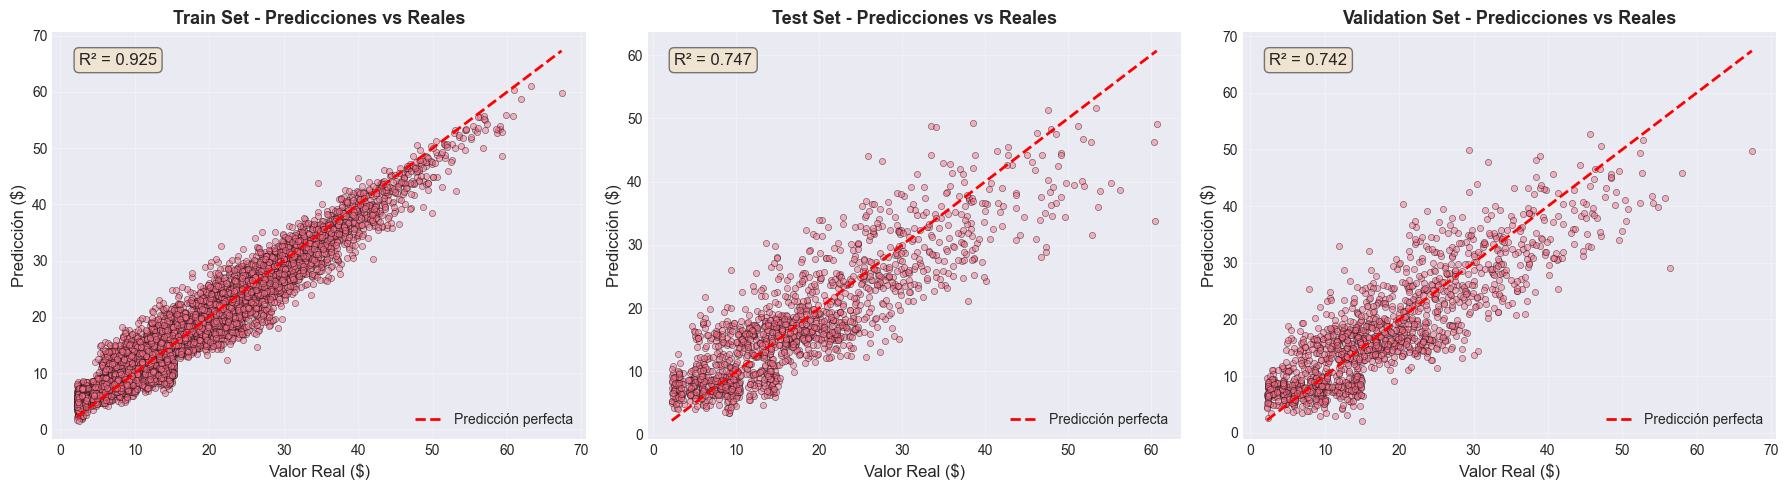

In [24]:
# Visualizar predicciones vs valores reales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, dataset) in enumerate([('Train', train_df), ('Test', test_df), ('Validation', val_df)]):
    y_true = dataset['total_venta'].values
    y_pred = regression_model.predict(dataset)['prediction'].values
    
    axes[idx].scatter(y_true, y_pred, alpha=0.5, s=20, edgecolor='black', linewidth=0.5)
    axes[idx].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                   'r--', lw=2, label='Predicción perfecta')
    axes[idx].set_xlabel('Valor Real ($)', fontsize=12)
    axes[idx].set_ylabel('Predicción ($)', fontsize=12)
    axes[idx].set_title(f'{name} Set - Predicciones vs Reales', fontsize=13, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    
    # Calcular R²
    from sklearn.metrics import r2_score
    r2 = r2_score(y_true, y_pred)
    axes[idx].text(0.05, 0.95, f'R² = {r2:.3f}', 
                   transform=axes[idx].transAxes, 
                   fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

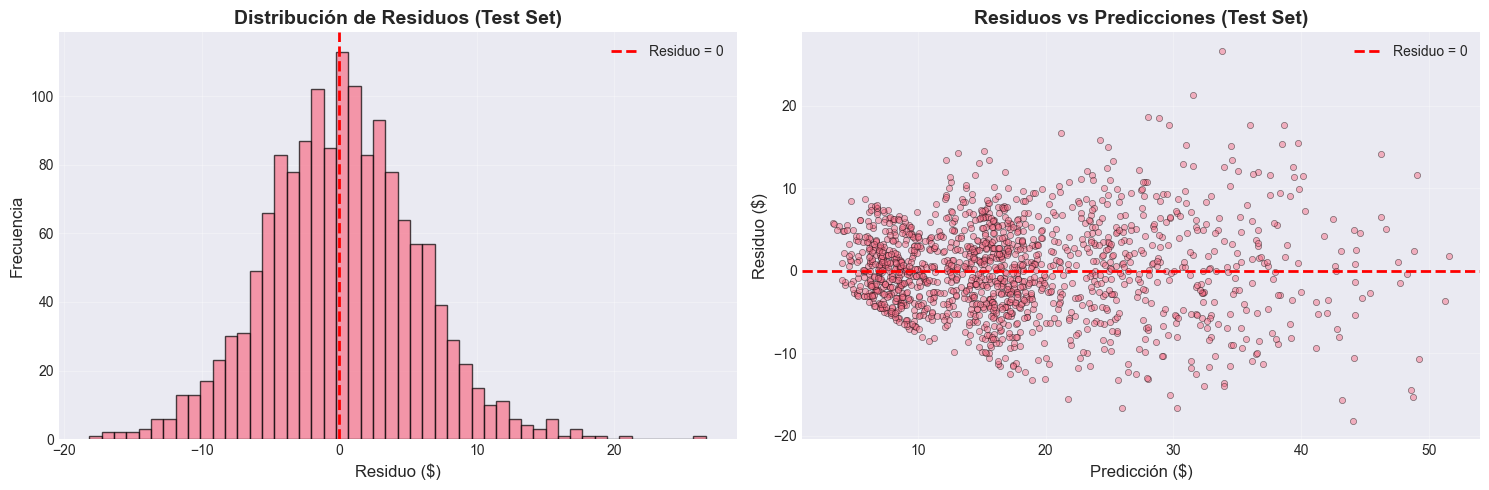


📊 Estadísticas de Residuos (Test Set):
  - Media: $0.18
  - Mediana: $0.22
  - Desviación Estándar: $5.54


In [25]:
# Análisis de residuos
y_test_true = test_df['total_venta'].values
y_test_pred = regression_model.predict(test_df)['prediction'].values
residuals = y_test_true - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribución de residuos
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Residuo = 0')
axes[0].set_xlabel('Residuo ($)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Residuos (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuos vs predicciones
axes[1].scatter(y_test_pred, residuals, alpha=0.5, s=20, edgecolor='black', linewidth=0.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2, label='Residuo = 0')
axes[1].set_xlabel('Predicción ($)', fontsize=12)
axes[1].set_ylabel('Residuo ($)', fontsize=12)
axes[1].set_title('Residuos vs Predicciones (Test Set)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Estadísticas de Residuos (Test Set):")
print(f"  - Media: ${residuals.mean():.2f}")
print(f"  - Mediana: ${np.median(residuals):.2f}")
print(f"  - Desviación Estándar: ${residuals.std():.2f}")


🎯 TOP 20 FEATURES MÁS IMPORTANTES (Modelo de Regresión):


,feature,importance
0,total_articulos,0.624990
1,customer_avg_ticket,0.026514
2,segmento_Premium,0.025759
3,customer_ticket_std,0.015789
4,customer_avg_items,0.014053
5,id_tienda_STORE_08,0.012398
6,clima_Rainy,0.011704
7,id_tienda_STORE_10,0.010658
8,id_tienda_STORE_02,0.010616
9,n_promociones_activas,0.010355


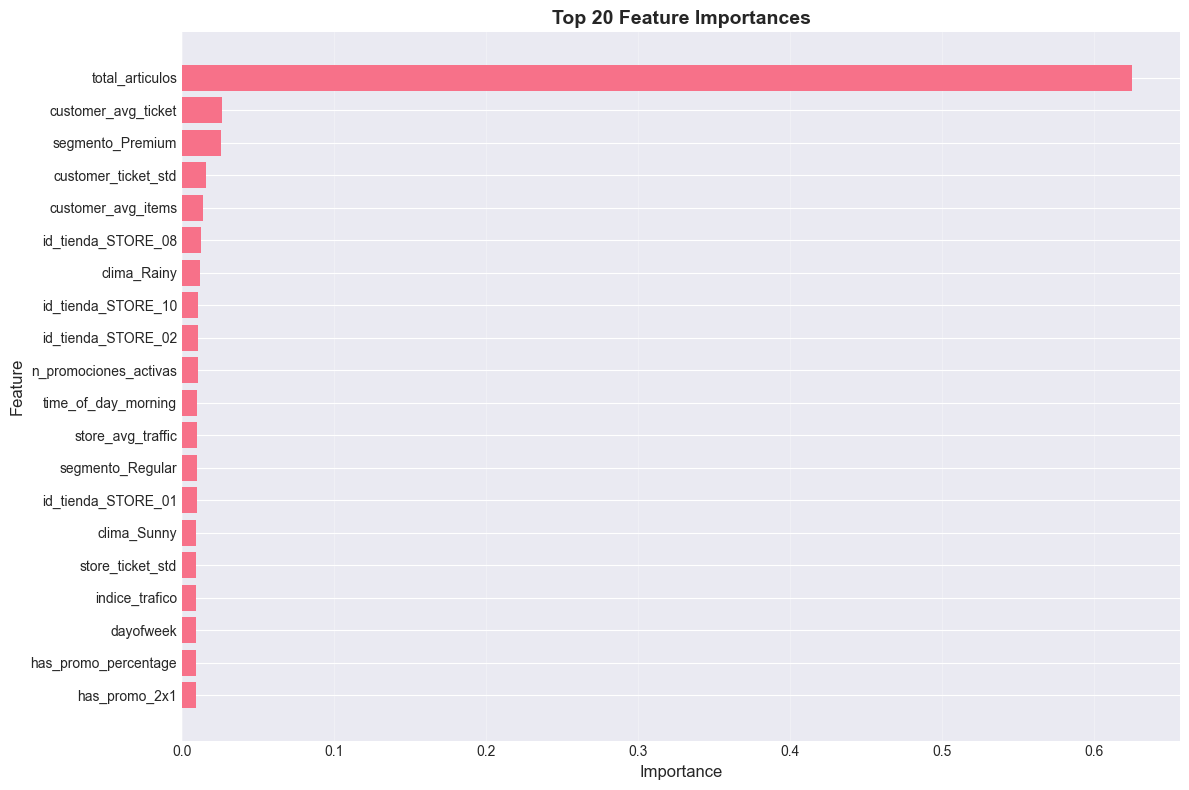

In [26]:
# Feature Importance del modelo de regresión
importance_df_reg = regression_model.get_feature_importance(top_n=20)

print("\n🎯 TOP 20 FEATURES MÁS IMPORTANTES (Modelo de Regresión):")
print("="*60)
display(importance_df_reg)

# Visualizar
fig = regression_model.plot_feature_importance(top_n=20, figsize=(12, 8))
plt.show()

## 7. Modelo de Clasificación - Ticket Alto vs Bajo

In [27]:
# Configuración del modelo de clasificación
columns_config_clf = {
    "numerical_features": numerical_features,
    "categorical_features": categorical_features,
    "target": ["is_high_ticket"],
    "metadata": []
}

model_metadata_clf = {
    "hyperparameters": {
        "n_estimators": 200,
        "max_depth": 6,
        "learning_rate": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "random_state": 42,
        "n_jobs": -1
    }
}

# Crear y entrenar modelo de clasificación
print("🚀 Entrenando modelo de CLASIFICACIÓN...")
classification_model = ModelManager(
    columns=columns_config_clf,
    model_metadata=model_metadata_clf,
    model_type="classification",
    scale_numeric=False
)

classification_model.train_model(train_df)
print("✅ Modelo de clasificación entrenado")

🚀 Entrenando modelo de CLASIFICACIÓN...
✅ Modelo de clasificación entrenado


In [28]:
# Evaluar modelo de clasificación
artifacts_clf, metrics_clf = classification_model.evaluate_model(train_df, test_df, val_df)

print("\n📊 MÉTRICAS DEL MODELO DE CLASIFICACIÓN:")
print("="*60)
metrics_clf_df = pd.DataFrame(metrics_clf)
for dataset in ['train', 'test', 'oot']:
    print(f"\n{dataset.upper()}:")
    dataset_metrics = metrics_clf_df[metrics_clf_df['dataset'] == dataset]
    for _, row in dataset_metrics.iterrows():
        print(f"  - {row['name']}: {row['value']:.4f}")


📊 MÉTRICAS DEL MODELO DE CLASIFICACIÓN:

TRAIN:
  - roc_auc: 0.9992
  - accuracy: 0.9860
  - f1_score: 0.9861

TEST:
  - roc_auc: 0.9190
  - accuracy: 0.8113
  - f1_score: 0.8149

OOT:
  - roc_auc: 0.9287
  - accuracy: 0.8347
  - f1_score: 0.8404


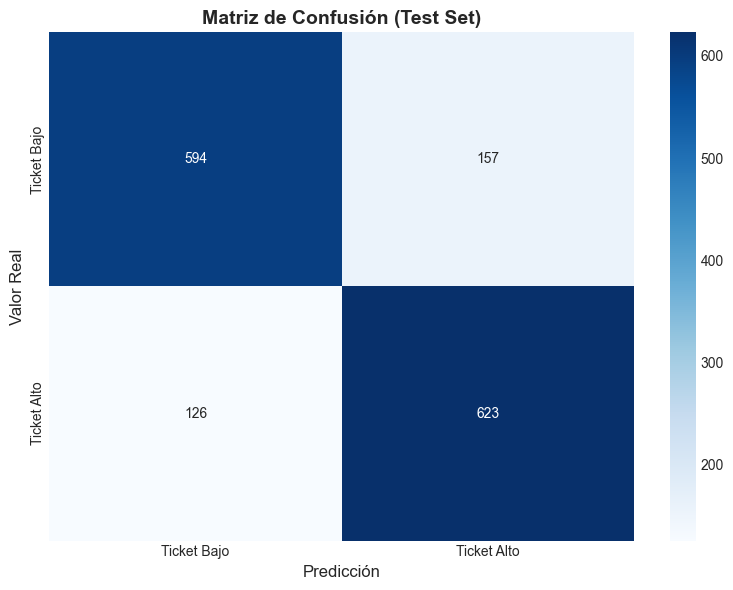


📊 Classification Report (Test Set):
              precision    recall  f1-score   support

 Ticket Bajo       0.82      0.79      0.81       751
 Ticket Alto       0.80      0.83      0.81       749

    accuracy                           0.81      1500
   macro avg       0.81      0.81      0.81      1500
weighted avg       0.81      0.81      0.81      1500



In [29]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_test_true_clf = test_df['is_high_ticket'].values
y_test_pred_proba = classification_model.predict(test_df)['score'].values
y_test_pred_clf = (y_test_pred_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test_true_clf, y_test_pred_clf)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=['Ticket Bajo', 'Ticket Alto'],
            yticklabels=['Ticket Bajo', 'Ticket Alto'])
ax.set_xlabel('Predicción', fontsize=12)
ax.set_ylabel('Valor Real', fontsize=12)
ax.set_title('Matriz de Confusión (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Classification Report (Test Set):")
print(classification_report(y_test_true_clf, y_test_pred_clf, 
                           target_names=['Ticket Bajo', 'Ticket Alto']))

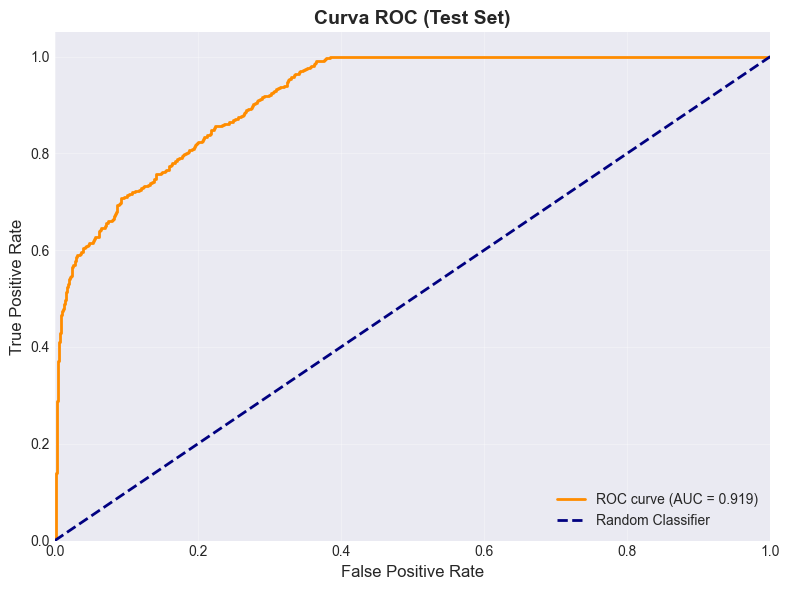

In [30]:
# Curva ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_true_clf, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Curva ROC (Test Set)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


🎯 TOP 20 FEATURES MÁS IMPORTANTES (Modelo de Clasificación):


,feature,importance
0,total_articulos,0.533895
1,customer_avg_ticket,0.022260
2,segmento_Premium,0.019563
3,segmento_Regular,0.017386
4,customer_avg_items,0.015484
5,id_tienda_STORE_05,0.014643
6,clima_Rainy,0.014433
7,id_tienda_STORE_02,0.014397
8,customer_ticket_std,0.014298
9,segmento_Budget,0.012976


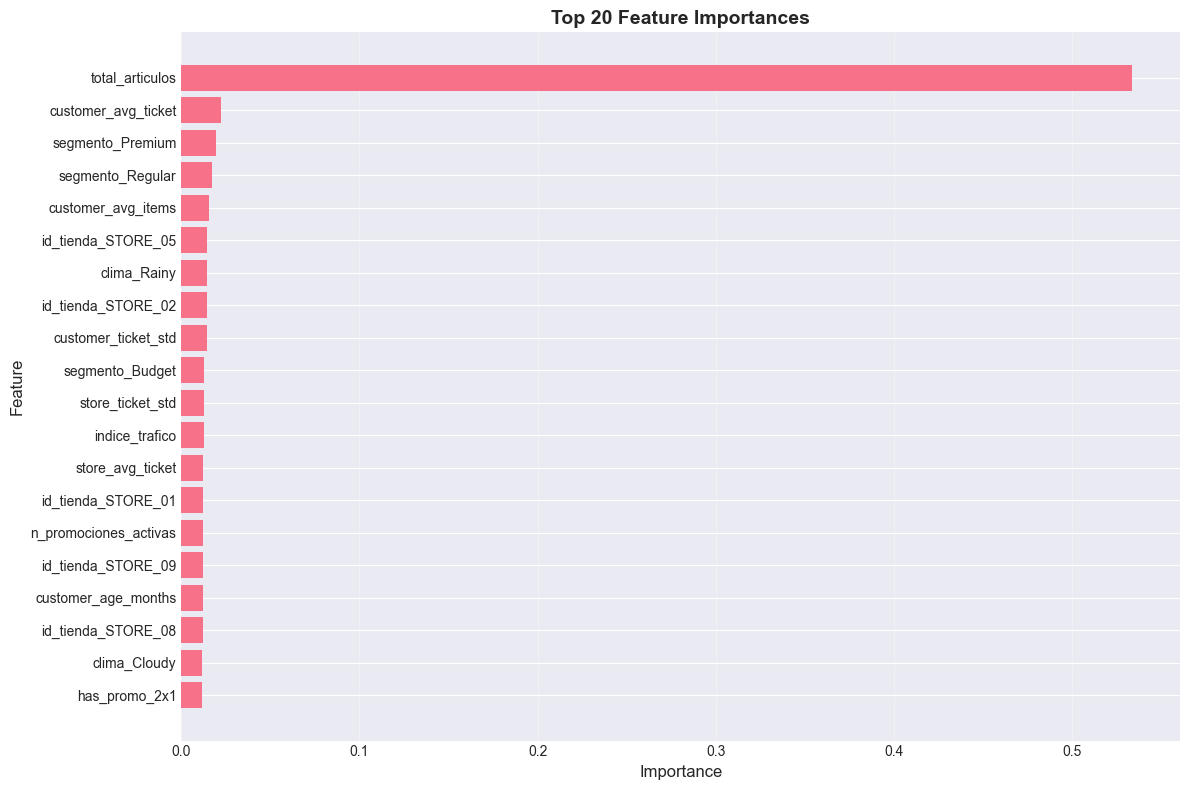

In [31]:
# Feature Importance del modelo de clasificación
importance_df_clf = classification_model.get_feature_importance(top_n=20)

print("\n🎯 TOP 20 FEATURES MÁS IMPORTANTES (Modelo de Clasificación):")
print("="*60)
display(importance_df_clf)

# Visualizar
fig = classification_model.plot_feature_importance(top_n=20, figsize=(12, 8))
plt.show()

## 8. Análisis de Feature Importance - Insights de Negocio

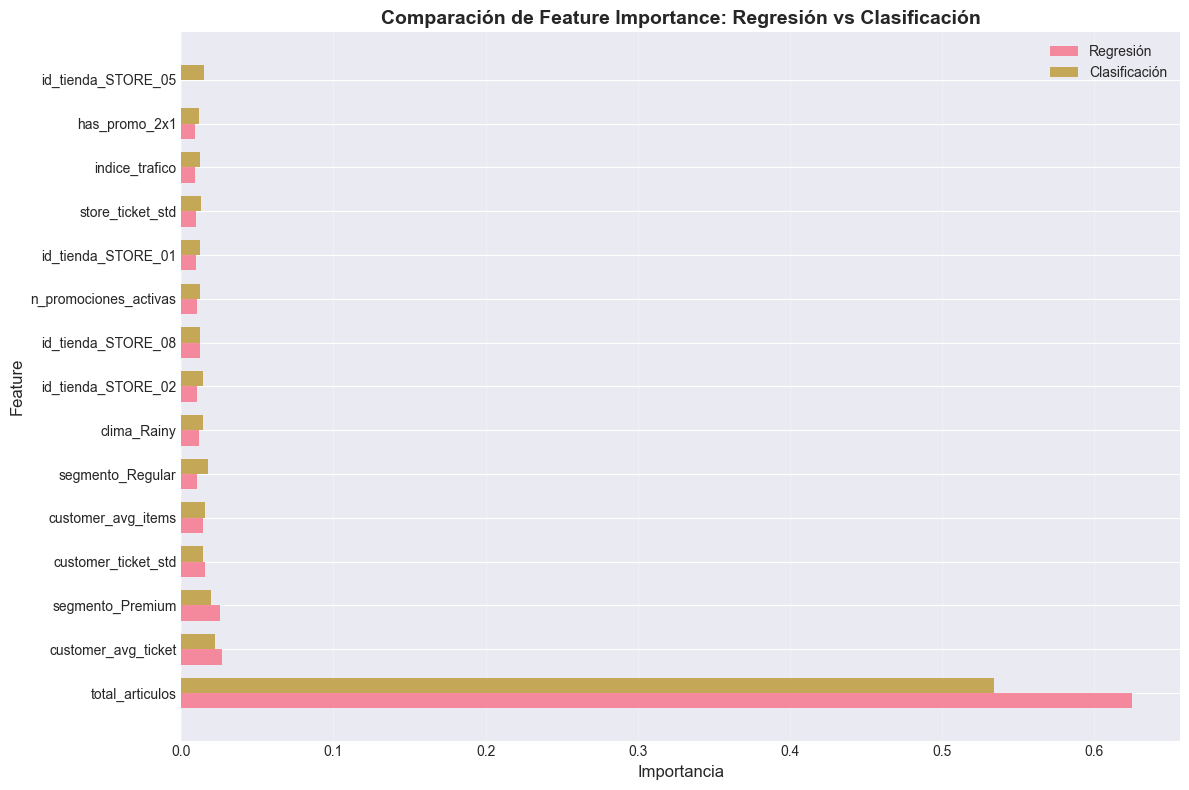


📊 TOP 15 FEATURES - Comparación entre modelos:


,feature,importance_regression,importance_classification,total_importance
25,total_articulos,0.624990,0.533895,1.158885
5,customer_avg_ticket,0.026514,0.022260,0.048774
19,segmento_Premium,0.025759,0.019563,0.045322
6,customer_ticket_std,0.015789,0.014298,0.030087
4,customer_avg_items,0.014053,0.015484,0.029537
20,segmento_Regular,0.010126,0.017386,0.027511
1,clima_Rainy,0.011704,0.014433,0.026137
11,id_tienda_STORE_02,0.010616,0.014397,0.025014
13,id_tienda_STORE_08,0.012398,0.011965,0.024363
17,n_promociones_activas,0.010355,0.012402,0.022757


In [32]:
# Comparar feature importance entre ambos modelos
comparison_df = pd.merge(
    importance_df_reg[['feature', 'importance']].rename(columns={'importance': 'importance_regression'}),
    importance_df_clf[['feature', 'importance']].rename(columns={'importance': 'importance_classification'}),
    on='feature',
    how='outer'
).fillna(0)

# Ordenar por suma de importancias
comparison_df['total_importance'] = comparison_df['importance_regression'] + comparison_df['importance_classification']
comparison_df = comparison_df.sort_values('total_importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.barh(x - width/2, comparison_df['importance_regression'], width, 
                label='Regresión', alpha=0.8)
bars2 = ax.barh(x + width/2, comparison_df['importance_classification'], width, 
                label='Clasificación', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison_df['feature'])
ax.set_xlabel('Importancia', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Comparación de Feature Importance: Regresión vs Clasificación', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📊 TOP 15 FEATURES - Comparación entre modelos:")
display(comparison_df)

## 9. Insights y Conclusiones

In [33]:
print("="*80)
print("🎯 RESUMEN DE RESULTADOS - CASO C: MODELADO DE TICKET PROMEDIO (AOV)")
print("="*80)

print("\n📊 MODELO DE REGRESIÓN (Predicción del valor exacto del ticket):")
print("-" * 80)
test_metrics_reg = metrics_reg_df[metrics_reg_df['dataset'] == 'test']
for _, row in test_metrics_reg.iterrows():
    print(f"  {row['name'].upper():20s}: {row['value']:.4f}")

print("\n📊 MODELO DE CLASIFICACIÓN (Ticket Alto vs Bajo):")
print("-" * 80)
test_metrics_clf = metrics_clf_df[metrics_clf_df['dataset'] == 'test']
for _, row in test_metrics_clf.iterrows():
    print(f"  {row['name'].upper():20s}: {row['value']:.4f}")

print("\n🔍 TOP 5 FACTORES MÁS IMPORTANTES (Modelo de Regresión):")
print("-" * 80)
for idx, row in importance_df_reg.head(5).iterrows():
    print(f"  {idx+1}. {row['feature']:40s} - Importancia: {row['importance']:.4f}")

print("\n🔍 TOP 5 FACTORES MÁS IMPORTANTES (Modelo de Clasificación):")
print("-" * 80)
for idx, row in importance_df_clf.head(5).iterrows():
    print(f"  {idx+1}. {row['feature']:40s} - Importancia: {row['importance']:.4f}")

print("\n" + "="*80)

🎯 RESUMEN DE RESULTADOS - CASO C: MODELADO DE TICKET PROMEDIO (AOV)

📊 MODELO DE REGRESIÓN (Predicción del valor exacto del ticket):
--------------------------------------------------------------------------------
  RMSE                : 5.5469
  MAE                 : 4.3422
  R2_SCORE            : 0.7472
  MAPE                : 0.3627

📊 MODELO DE CLASIFICACIÓN (Ticket Alto vs Bajo):
--------------------------------------------------------------------------------
  ROC_AUC             : 0.9190
  ACCURACY            : 0.8113
  F1_SCORE            : 0.8149

🔍 TOP 5 FACTORES MÁS IMPORTANTES (Modelo de Regresión):
--------------------------------------------------------------------------------
  1. total_articulos                          - Importancia: 0.6250
  2. customer_avg_ticket                      - Importancia: 0.0265
  3. segmento_Premium                         - Importancia: 0.0258
  4. customer_ticket_std                      - Importancia: 0.0158
  5. customer_avg_items     

## 10. Insights de Negocio

### Factores Clave que Influyen en el Ticket Promedio:

#### 1. **Factores Endógenos (Controlables por la empresa)**
- **Total de artículos**: Fuerte correlación positiva con el valor del ticket
- **Promociones activas**: Las promociones 2x1 y de porcentaje tienen impacto significativo
- **Características de la tienda**: El ticket promedio histórico de la tienda es un predictor importante
- **Horario**: El momento del día influye en el comportamiento de compra

#### 2. **Factores Exógenos (Externos)**
- **Índice de tráfico**: Mayor tráfico se asocia con diferentes patrones de compra
- **Índice de precios de competidores**: Afecta la decisión de compra del cliente
- **Clima**: Tiene un impacto moderado en el comportamiento de compra

#### 3. **Características del Cliente**
- **Segmento (Premium/Regular/Budget)**: Fuerte predictor del valor del ticket
- **Historial del cliente**: El ticket promedio histórico del cliente es muy relevante
- **Antigüedad**: La relación del cliente con la marca influye en su gasto
- **Edad**: Diferentes grupos etarios tienen patrones de gasto distintos

### Recomendaciones:

1. **Estrategia de Cross-selling**: Incentivar la compra de más artículos por transacción
2. **Segmentación de clientes**: Personalizar ofertas según el segmento del cliente
3. **Optimización de promociones**: Las promociones 2x1 y de porcentaje son efectivas
4. **Gestión por tienda**: Considerar las características específicas de cada tienda
5. **Timing**: Optimizar promociones según el horario y día de la semana

### Limitaciones y Consideraciones:

- El modelo de regresión tiene un MAPE que indica la precisión de las predicciones
- Existen outliers en el valor del ticket que pueden afectar las predicciones
- Se recomienda monitorear el desempeño del modelo en producción
- Considerar factores estacionales no capturados en el período de análisis